# Lesson 13, Workalong 01: Finding Earthquakes in California

This workalong uses `geopandas` to find earthquakes within California.  It builds from the [lesson 05 warmup](https://github.com/taobrienlbl/advanced_earth_science_data_analysis/blob/8fdbb61bc39b64244f420d446b985a4d27f80df6/lessons/05_multidimensional_arrays_also_plotting/05_warmup_SOLUTION.ipynb), in which we used pandas to find earthquakes from a USGS dataset.  We'll use a similar approach to initially load the same dataset.

In [1]:
""" Import libraries """
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import numpy as np

In [2]:
""" Load the usgs dataset """
dataset_path = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/1cc2bc06219f7c15b211629a2aeba7d57e783138/lessons/05_multidimensional_arrays_also_plotting/data/usgs_major_earthquakes_1900-2023.csv"

# use pandas to read the dataset
usgs_pd = pd.read_csv(
    dataset_path,
    header=0,
    parse_dates=[0],
    )

# show the top of the dataset
usgs_pd.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-09-21 21:11:49.950000+00:00,-14.0039,167.1898,188.419,6.1,mww,76.0,26.0,7.076,0.83,...,2023-09-21T23:17:30.631Z,"41 km WSW of Sola, Vanuatu",earthquake,8.86,4.898,0.054,33.0,reviewed,us,us
1,2023-09-20 14:45:58.609000+00:00,-4.5826,-105.6493,10.000,6.0,mww,110.0,208.0,15.828,1.08,...,2023-09-21T21:02:41.950Z,central East Pacific Rise,earthquake,14.99,1.952,0.050,38.0,reviewed,us,us
2,2023-09-18 13:21:23.790000+00:00,26.4336,125.3032,183.483,6.3,mww,113.0,35.0,2.262,1.21,...,2023-09-19T13:29:35.504Z,"180 km N of Hirara, Japan",earthquake,6.53,4.942,0.044,49.0,reviewed,us,us
3,2023-09-13 11:49:15.926000+00:00,-36.2201,-97.9378,10.000,6.1,mww,117.0,37.0,13.309,0.65,...,2023-09-14T11:52:11.466Z,West Chile Rise,earthquake,10.28,1.860,0.050,39.0,reviewed,us,us
4,2023-09-12 11:03:18.873000+00:00,19.2687,121.2178,41.281,6.3,mww,133.0,21.0,4.049,0.96,...,2023-09-18T13:59:24.715Z,"73 km N of Namuac, Philippines",earthquake,8.03,5.112,0.046,46.0,reviewed,us,us


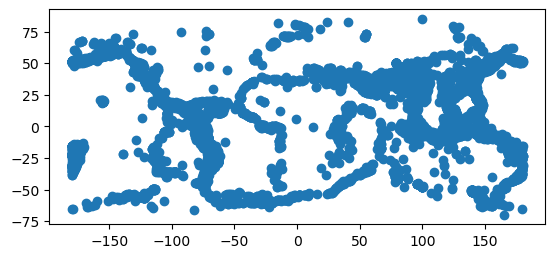

In [3]:
""" Convert the pandas dataframe into a geodataframe """

# convert the pandas dataframe into a geodataframe
usgs_gdf = gpd.GeoDataFrame(
    usgs_pd,
    geometry=gpd.points_from_xy(usgs_pd.longitude, usgs_pd.latitude),
    crs="EPSG:4326",
    )

# plot the geodataframe
usgs_gdf.plot();

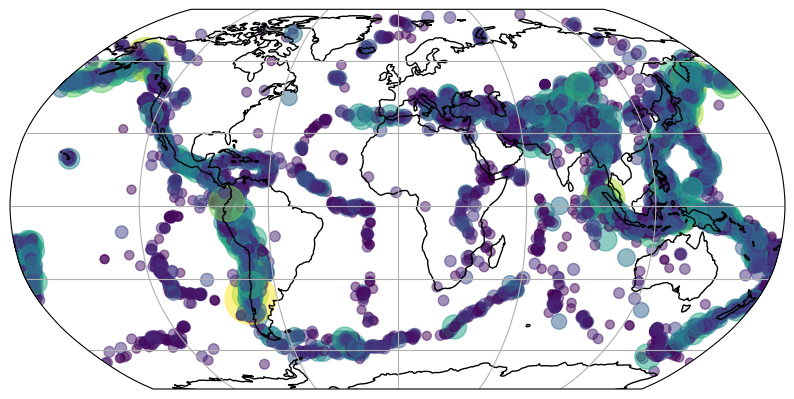

In [4]:
""" Plot the earthquakes by magnitude """
projection = cartopy.crs.Robinson()

# create a figure and axis
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={"projection": projection},
    )

# convert the projection to a PROJ4 string
ax_proj = ax.projection.proj4_init

# convert the usgs data to the projection
usgs_gdf_proj = usgs_gdf.to_crs(ax_proj)
usgs_gdf_proj.plot(
    ax = ax,
    transform= projection,
    column="mag",
    markersize = np.exp(usgs_gdf_proj.mag)/10,
    alpha= 0.5,
    )

# add geographic features
ax.coastlines()
# add gridlines
ax.gridlines()

plt.show()



## State boundaries

The next step involves filtering by state.  While technically we might be able to determine the location using the "place" column in the dataset, we can do better than that by using a shapefile to define the geospatial region we want to search and then using a point-in-polygon method to find earthquake points taht are within that region.

Note that this shapefile dataset was downloaded from  https://www.sciencebase.gov/catalog/item/52c78623e4b060b9ebca5be5 on Tuesday November 28, 2023 at 1:45pm Eastern.

In [5]:
""" Load the state boundary shapefile. """

state_shapefile_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/tl_2012_us_state.zip"

# load the shapefile
state_gdf = gpd.read_file(
    state_shapefile_path,
    )

state_gdf.head()


,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,1.663425e+10,1.167874e+10,+19.8097670,-155.5061027,2.419034e+06,3.268482e+10,"MULTIPOLYGON (((-17361760.204 2164544.588, -17..."
1,2,3,7,05,00068085,05,AR,Arkansas,00,G4000,A,1.347726e+11,2.959210e+09,+34.8955256,-092.4446262,2.656648e+06,2.053261e+11,"POLYGON ((-10515267.713 4101325.818, -10515269..."
2,3,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,3.141611e+11,7.564385e+08,+34.4346843,-106.1316181,2.900368e+06,4.643927e+11,"POLYGON ((-12138963.727 4106855.170, -12138964..."
3,4,4,8,30,00767982,30,MT,Montana,00,G4000,A,3.769636e+11,3.868565e+09,+47.0511771,-109.6348174,4.607246e+06,8.201836e+11,"POLYGON ((-12727480.235 5886876.586, -12727567..."
4,5,1,2,36,01779796,36,NY,New York,00,G4000,A,1.220579e+11,1.923885e+10,+42.9133974,-075.5962723,3.212630e+06,2.637702e+11,"MULTIPOLYGON (((-8866092.533 5160809.769, -886..."


Since this is a dataframe, we can use pandas features to select rows.  I'm going to pull the row where the "STUSPS" column is "CA".

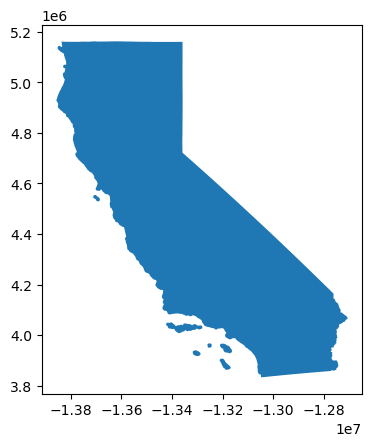

In [6]:
""" Extract the CA row. """

# extract the CA row
ca_gdf = state_gdf[state_gdf.STUSPS=="CA"]

ca_gdf.plot();

This particular shapefile seems to include coastal waters that are also part of the state (note how the islands look like dots).  That might not be great for some analyses, but for our purposes, that's just fine.

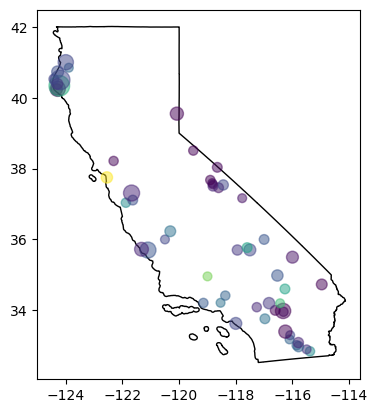

In [7]:
""" Use the CA boundary to clip the earthquakes. """

# convert the CA boundary to the projection of the earthquake dataset
ca_gdf_proj = ca_gdf.to_crs(usgs_gdf.crs)

# clip the earthquakes to the CA boundary
usgs_gdf_clipped = gpd.clip( usgs_gdf, ca_gdf_proj)

# plot the boundary and the clipped earthquakes
fig, ax = plt.subplots()
ca_gdf_proj.plot(ax=ax, facecolor="none", edgecolor="black")

usgs_gdf_clipped.plot(
    ax = ax,
    column="mag",
    markersize = np.exp(usgs_gdf_proj.mag)/10,
    alpha= 0.5,
    )

plt.show()

What if we want earthquakes near CA: e.g., within 100 km?  We can inflate (*buffer*) the shapefile boundary to accomplish this.

Note, however, that the shapefile uses a degree-based coordinate system, so we'll *buffer* by degrees, using the fact that 1 degree is approximately 100 km.

In [8]:
""" Inflate the CA shapefile boundary. """


' Inflate the CA shapefile boundary. '

/var/folders/0s/yp78v9d15qd8pmgtc3xknpfh37trx3/T/ipykernel_19894/2387912537.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_boundary_inflated = ca_gdf_proj.buffer(1)


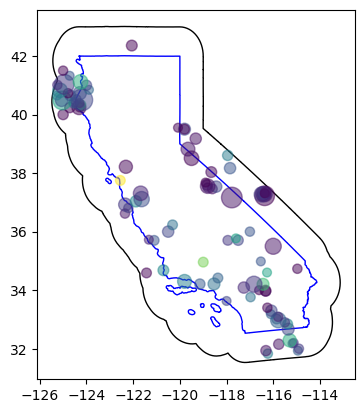

In [9]:
""" Save the inflated boundary to a shapefile for later use. """
# inflate the boundary by 1 degree
ca_boundary_inflated = ca_gdf_proj.buffer(1)

# clip the earthquakes to the inflated boundary
usgs_gdf_clipped = gpd.clip( usgs_gdf, ca_boundary_inflated)

# plot the boundary and the clipped earthquakes
fig, ax = plt.subplots()
ca_gdf_proj.plot(ax=ax, facecolor="none", edgecolor="blue")
ca_boundary_inflated.plot(ax=ax, facecolor="none", edgecolor="black")

usgs_gdf_clipped.plot(
    ax = ax,
    column="mag",
    markersize = np.exp(usgs_gdf_proj.mag)/10,
    alpha= 0.5,
    )

plt.show()

In [10]:
""" Save the clipped earthquakes for later use. """

# convert dates to strings
usgs_gdf_clipped_tmp = usgs_gdf_clipped.copy()
usgs_gdf_clipped_tmp["time"] = usgs_gdf_clipped_tmp["time"].astype(str)

# save the clipped earthquakes to a shapefile
usgs_gdf_clipped_tmp.to_file("ca_earthquakes.shp.zip", driver="ESRI Shapefile")

/var/folders/0s/yp78v9d15qd8pmgtc3xknpfh37trx3/T/ipykernel_19894/3607542243.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  usgs_gdf_clipped_tmp.to_file("ca_earthquakes.shp.zip", driver="ESRI Shapefile")
